# Apparel Recommendations usin Convolutional Neural Network

## Get the feature vectors of all apparel images

<pre>
   Running this cell will take time, you can skip running this cell. you can download the feature vectors from given link
   16k_data_cnn_features.npy: https://drive.google.com/open?id=0BwNkduBnePt2c1BkNzRDQ1dOVFk 
   bottleneck_features_cnn.npy : https://drive.google.com/open?id=0BwNkduBnePt2ODRxWHhUVzIyWDA
</pre>

In [2]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1050 (0000:01:00.0)


In [26]:
# https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html


# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'images2/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('workshop/models/16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('workshop/models/16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()

Found 16042 images belonging to 1 classes.


# load the extracted features

In [48]:
bottleneck_features_train = np.load('workshop/models/16k_data_cnn_features.npy')
asins = np.load('workshop/models/16k_data_cnn_feature_asins.npy')

## get the most similar apparels using euclidean distance measure

In [49]:
data = pd.read_pickle('workshop/pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])
asins = list(asins)

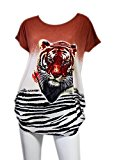

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 0.0625
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


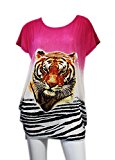

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 30.0501
Amazon Url: www.amzon.com/dp/B00JXQASS6


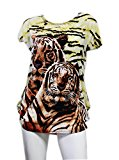

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 41.2611
Amazon Url: www.amzon.com/dp/B00JXQCUIC


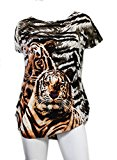

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 44.0002
Amazon Url: www.amzon.com/dp/B00JXQCWTO


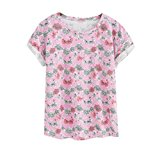

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 47.3825
Amazon Url: www.amzon.com/dp/B071FCWD97


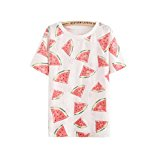

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 47.7184
Amazon Url: www.amzon.com/dp/B01JUNHBRM


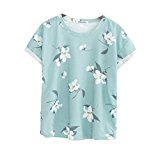

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 47.9021
Amazon Url: www.amzon.com/dp/B071SBCY9W


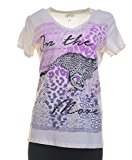

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 48.0465
Amazon Url: www.amzon.com/dp/B01CUPYBM0


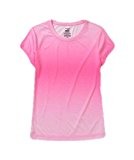

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 48.1019
Amazon Url: www.amzon.com/dp/B01F7PHXY8


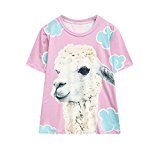

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 48.1189
Amazon Url: www.amzon.com/dp/B01I80A93G


In [50]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo

def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(12566, 10)

In [1]:
# with GPU => per image 3.5/20 (0.175 sec), for whole data set its taking around 40min
# with CPU => per image 12.3/20 (0.615 sec), for whole data set its taking around 160min